In [1]:
# Dependencies
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cv2 as cv
# Own Dependencies
from lib.Visualize import visualize_points_and_circle,show_images
from lib.RANSAC import Ransac,Circle,Homography

### $Q_1$ : Circle Fitting

In [2]:

# Points Generation
N = 100
half_n = N//2

R = 10
s = R/16
t = np.random.uniform(0, 2*np.pi ,half_n)
n = s*np.random.randn(half_n)

x ,y = (R + n)*np.cos(t), (R + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

In [3]:
# Using Ransac to get the model
threshold = 1
ransac_run = Ransac(X,threshold,'circle')
circle,final_model,model_points = ransac_run.get_model()
inliers,outliers = ransac_run.get_inliers_outliers()
print(ransac_run)

Model Parameters : 
 X=0.050733 Y=-0.114377 R=10.011585
Number of Samples = 100 
 Iterations Done = 18
 Inliers Count : 54


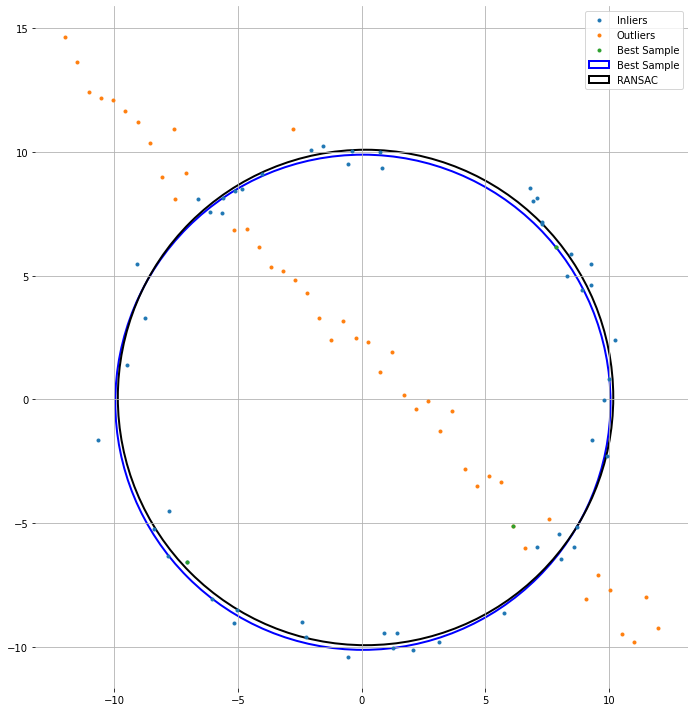

In [4]:

visualize_points_and_circle([inliers,outliers,model_points],[[circle,'blue'],[final_model,'black']],legends=[["Inliers",'Outliers',"Best Sample"],['Best Sample','RANSAC']],grid=True)

### $Q_2$ : Super Impose Image

In [10]:
# Function to create overlay
def overlay_image(im_src,im_dst,pts_src,pts_dst):
    h = cv.getPerspectiveTransform(pts_src, pts_dst)
    transformed_image=cv.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
    b = (transformed_image[:,:,0]==0)*im_dst[:,:,0]
    g=(transformed_image[:,:,1]==0)*im_dst[:,:,1]
    r=(transformed_image[:,:,2]==0)*im_dst[:,:,2]
    masked=np.dstack((b,g,r))
    overlayed=cv.add(masked,transformed_image)
    return overlayed

# Importing Images
ice_age = cv.imread(r'./images/ice-age.webp')
virumandi = cv.imread(r'./images/virumandi.jpg')
image = cv.imread(r'./images/times_square_night.jpg')
assert ice_age is not None
assert virumandi is not None
assert image is not None

In [11]:
# Function for getting co-ordinates by mouse click
def click_event(event,x,y,flags,params):
    if event==cv.EVENT_LBUTTONDOWN:
        print(x,' ',y)
        

cv.imshow('image',image)
cv.setMouseCallback('image',click_event)
cv.waitKey(0)
cv.destroyAllWindows()

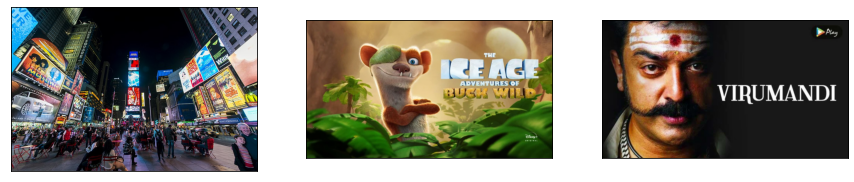

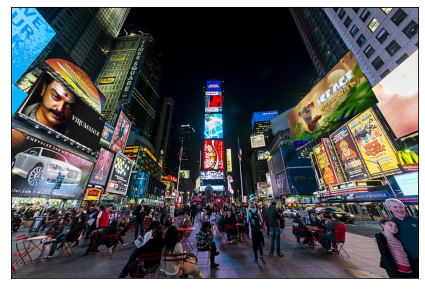

In [12]:
# Defining Points to find homography
iceAge_src = np.float32([[0, 0], [ice_age.shape[0], 0], [ice_age.shape[0], ice_age.shape[1]], [0, ice_age.shape[1]]])
ice_age_dst = np.float32([[540, 215], [593,160],[653,327],[573,344]])

virumandi_src = np.float32([[0, 0], [virumandi.shape[0], 0], [virumandi.shape[0], virumandi.shape[1]], [0, virumandi.shape[1]]])
virumandi_dst = np.float32([[68,128], [145,190],[90,330],[-35,295]])

final1 = overlay_image(ice_age,image,iceAge_src,ice_age_dst)
final2 = overlay_image(virumandi,final1,virumandi_src,virumandi_dst)
show_images([[image],[ice_age],[virumandi]],size=5)
show_images([[final2]],size=20)

### $Q_3$ : Image Stiching

Number of Good Matches :  87


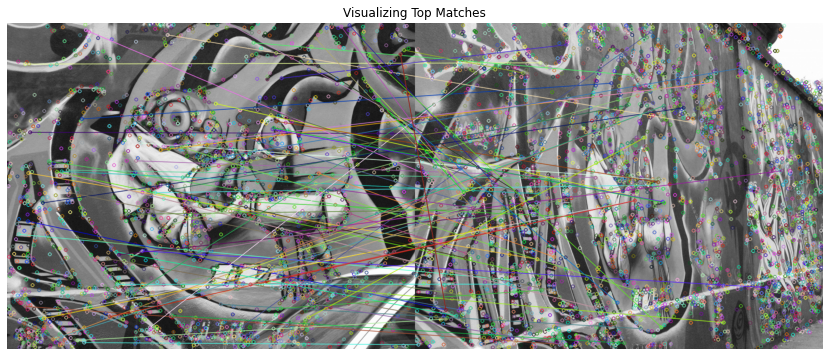

In [8]:
# Extracting Co-ordinates of matching points using SIFT Operator
f1=cv.imread('./images/graffiti/img1.ppm',cv.IMREAD_GRAYSCALE)
assert f1 is not None

f2=cv.imread('./images/graffiti/img5.ppm',cv.IMREAD_GRAYSCALE)
assert f2 is not None

sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(f1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(f2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2, k=2)

# Apply ratio test
good ,good_matches= [],[]
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        good_matches.append(m)

matching_points = np.array([[keypoints_1[mat.queryIdx].pt, keypoints_2[mat.trainIdx].pt]  for mat in good_matches ])

# Visualization
f3 = cv.drawMatchesKnn(f1,keypoints_1,f2,keypoints_2,good,None)
print("Number of Good Matches : ", len(good))

fig = plt.figure(figsize=(18, 6))
plt.imshow(f3)
plt.axis("off")
plt.title("Visualizing Top Matches")
plt.show()


In [13]:
# Using Ransac to get the model
threshold = 800
ransac_run = Ransac(matching_points,threshold,'homo')
H,final_model,_ = ransac_run.get_model()
print(ransac_run)

Model Parameters : 
 0.051932	-0.018284	-0.001731 
-0.051932	0.018284	0.001731 
-0.001709	0.002951	-0.996955
Number of Samples = 87 
 Iterations Done = 2
 Inliers Count : 82


In [10]:
# Reading Original Transformation
with open("./images/graffiti/H1to5p", "r") as txt_file:
  h_r= txt_file.readlines()
h_r=[list(map(float,line.split())) for line in h_r]
r_t = Homography(h_r)
print('Real Transformation :\n',r_t)

Real Transformation :
 0.625446	0.057759	222.012170 
0.222405	1.165215	-25.605611 
0.000492	-0.000037	1.000000
